In [5]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [6]:
#datasets
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'
#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [7]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    data_trunc = data[clinical_scale + feature_cols]
    data_trunc = data_trunc.dropna(subset = clinical_scale + feature_cols, how='any')
    X = np.asarray(data_trunc[feature_cols], dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):

    data = pd.read_pickle(in_file)
    data_trunc = data[clinical_scale + feature_cols]
    # remove nans
    data_trunc = data_trunc[np.isfinite(data_trunc[clinical_scale])]
    X = np.asarray(data_trunc[feature_cols],dtype=float)
    y = np.asarray(data_trunc[clinical_scale],dtype=float)
    return {'X':X, 'y':y}

In [51]:
feature_cols = ['L_HC_VOL','R_HC_VOL']
var_names = feature_cols
clinical_scale = ['ADAS13']

cv_data = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
#test_data = load_test_data(test_file, feature_cols, clinical_scale)

(522, 2)


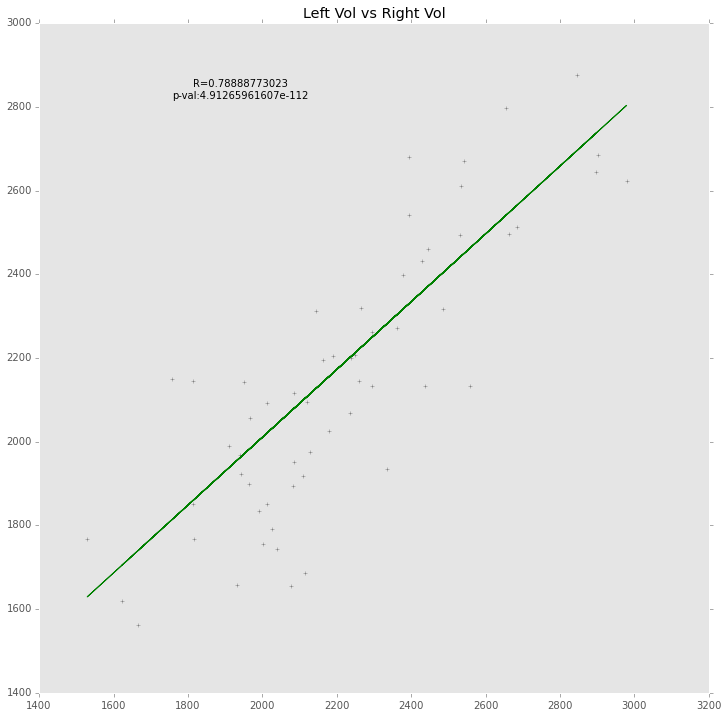

In [9]:
import scipy

# Some notes about the two hippocampal volume variables:

# First, a test for correlation between the two sides using only training data and no clinical scores:
#X_vol = np.concatenate([cv_data['X_train'][fold] for fold in range(10)])
X_vol = cv_data['X_train'][0]
X_vol_v = cv_data['X_valid'][0]
print X_vol.shape
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_vol[:,0], X_vol[:,1])
y_hat_v = intercept + slope * X_vol_v[:,0]
        
# Plot outputs
ax=plt.subplot(1,1,1)
plt.title('Left Vol vs Right Vol')
plt.scatter(X_vol_v[:,0], X_vol_v[:,1], marker='+', color='gray')
plt.plot(X_vol_v[:,0], y_hat_v, color='green', linewidth=1)
plt.text(0.3, 0.9,'R={}\np-val:{}'.format(r_value, p_value), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

plt.grid()    
plt.show()

In [125]:
# Define a model

# The two independent vars are highly correlated, so an ordinary least squares regression may
# be the best idea: the model will be highly sensitive to random errors in the response var. See 
# https://en.wikipedia.org/wiki/Multicollinearity

# Space for hyperparam search
alphas=np.logspace(-5,5,num=100)

# We can instead try a ridge regression:
from sklearn import linear_model
from sklearn.metrics import r2_score
BaseReg=linear_model.RidgeCV
    
class Regression(BaseReg):
    def __init__(self, *args, **kwargs):
        super(Regression, self).__init__(*args,**kwargs)
    

    def fit(self, X, y):
        self = super(Regression, self).fit(X,y)
        df = X.shape[0] - X.shape[1] - 1
        y_hat = self.predict(X)
        sse = np.sum(np.square(y - y_hat), axis=0)
        self.variance_y = sse/df
        self.variance_X = (np.matrix(X).T * np.matrix(X)).I
        self.zscores_ = self.coef_ / np.sqrt(self.variance_y * self.variance_X.diagonal())
        self.pvals_ = 1 - scipy.stats.t.cdf(abs(self.zscores_), df)
    
    def score(self, X, y):
        N, P = X.shape
        y_hat = self.predict(X)
        
        # R2 and adjusted R2:
        self.R2 = r2_score(y, y_hat)
        self.mse = mean_squared_error(y, y_hat)
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_y = np.var(y)
        
        self.ssm = np.sum(np.square(y_hat - y.mean()))
        self.sse = np.sum(np.square(y - y_hat))
        self.sst = np.sum(np.square(y - y.mean()))
        
        self.r = scipy.stats.pearsonr(y, y_hat)
        
        return self.R2
        

if BaseReg==linear_model.RidgeCV:
    reg = Regression(alphas=alphas, normalize=False, fit_intercept=True)
else:
    reg = Regression(normalize=False, fit_intercept=True)

In [126]:
from sklearn.metrics import mean_squared_error, r2_score

# Cross-validation loop
stats = []
coefs = []
alphas = []
zscores = []
pvals = []

for fold in range(len(cv_data['X_train'])):
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold]
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold]

    reg.fit(X, y)
    y_hat = reg.predict(X)
    # validation:
    y_hat_v = reg.predict(X_v)
    mse = mean_squared_error(y_v, y_hat_v)
    reg.score(X_v, y_v)
    stats.append((reg.R2, reg.adj_R2, reg.mse, reg.r[0][0], reg.r[1][0]))
    
    try:
        alphas.append(reg.alpha_)
    except:
        pass
    coefs.append(reg.coef_)
    zscores.append(reg.zscores_)
    pvals.append(reg.pvals_)
    

In [127]:
def make_table(k, var_names, **kwargs):
    header_mean = ['Mean {}'.format(key) for key in kwargs.keys()]
    header_std = ['Std {}'.format(key) for key in kwargs.keys()]
    header = header_mean + header_std
    header[::2]=header_mean
    header[1::2]=header_std
    header = ['Variables'] + header
    table = np.zeros(shape=(len(var_names),2 * len(kwargs.keys())))
    for i, stat in enumerate(kwargs.values()):
        M=stat.reshape(k,-1).T
        table[:, i*2] = np.mean(M,axis=1)
        table[:, (i*2)+1] = np.std(M,axis=1)
    
    frame = pd.DataFrame(table)
    frame.insert(0, 'Variable', var_names)
    frame.columns = header
    return frame

In [128]:
from IPython.display import display

stats = np.array(stats)
coefs = np.array(coefs)
alphas = np.array(alphas)
zscores = np.array(zscores)
pvals = np.array(pvals)
alpha=scipy.stats.mode(alphas)[0][0]
print 'Mode of regularization param: {}'.format(alpha)

model=make_table(10, ['Model'], R2=stats[:,0], Adj_R2=stats[:,1], MSE=stats[:,2], r=stats[:,3], pval=stats[:,4])
display(model)
table = make_table(10, var_names, coefs=coefs, zscores=zscores, pvals=pvals)
table=table.sort(['Mean pvals'], ascending=[1])
display(table)




Mode of regularization param: 100000.0


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean MSE,Std MSE,Mean r,Std r,Mean R2,Std R2
0,Model,-0.913476,0.081223,0.118,0.12729,74.66074,14.853289,0.246598,0.084563,0.043262,0.040611


,Variables,Mean zscores,Std zscores,Mean pvals,Std pvals,Mean coefs,Std coefs
1,R_HC_VOL,-2.790622,0.246976,0.003483,0.002552,-0.005639,0.000543
0,L_HC_VOL,-1.291083,0.380368,0.114520,0.080097,-0.002560,0.000744
